# Freeform modelling with Maximum Entropy

Freeform modelling involves the use of a very flexible profile that can describe a wide range of possible structures. Maximum entropy is a freeform approach first applied to neutron reflectometry by [Sivia et al](https://www.sciencedirect.com/science/article/abs/pii/092145269190042D) in 1991. 
Maximum entropy is very useful when the structure of a system is totally unknown. Once a structure is obtained it's often possible to use it as a springboard for developing a further model.

It involves describing the region of unknown structure with a series of pixels. The SLD of these pixels are allowed to vary over a range. Usually fitting with such a large number of pixels would lead to a very noisy solution, which is typically incorrect, because of the large number of parameters. The Maximum Entropy approach smooths the solution by adding an entropic prior to the log-probability of the model:

$ S = \frac{1}{\alpha} \sum_{j}^{} \beta_j - m_j - \beta_j \log(\frac{\beta_j}{m_j}) $

where $\beta_j$ is the SLD of each pixel, $m_j$ is a default model for each pixel, and $\alpha$ is a scaling value to control the size of $S$. In this example we will assume that $m_j$ is a constant. The further $\beta_j$ lies from $m_j$ the larger $S$ becomes.

The [maxent_general](https://github.com/refnx/refnx-models/blob/main/MaxEntVFP/maxent_general.py) file contains `MaxEnt`, a refnx `Component` that can carry out this kind of Maximum Entropy modelling.

In that Component we scale the contribution of $S$ to the log-probability by dividing it by a value $\alpha$. In the example below we add $\alpha$ to the set of Parameter being varied, by specifying it as an `auxiliary_param` when we create the `Objective`.

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

from refnx.dataset import Data1D
from refnx.analysis import Parameter, CurveFitter, Objective, PDF, Transform
from refnx.reflect import ReflectModel, SLD, Slab

from maxent_general import MaxEnt

In [2]:
# create a random number generator so this notebook becomes reproducible by others
rng = np.random.default_rng(23498342098342908)

The example we're going to use is simulated from [Karim et al.](https://doi.org/10.1103/PhysRevLett.73.3407) who were studying grafted polystyrene brushes in cyclohexane and toluene. The polymer brush has a concentration gradient towards the bulk, which means that the SLD profile also follows a gradient. Here we know ahead of time what the SLD profile that generates the data should look like.

In [3]:
# load the dataset
# data is simulated from https://doi.org/10.1103/PhysRevLett.73.3407, fig2 in toluene.
data = Data1D('karim_simulation.dat')
known_sld_profile = np.loadtxt('karim_sld_profile.dat')

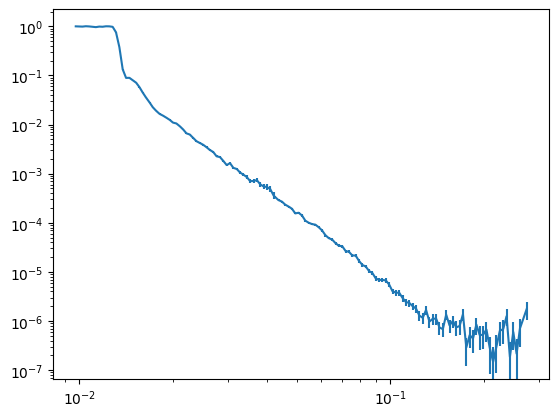

In [4]:
data.plot()
plt.yscale('log')
plt.xscale('log')

Here is the 'known' SLD profile. We want to try to recreate it via a Freeform approach. 

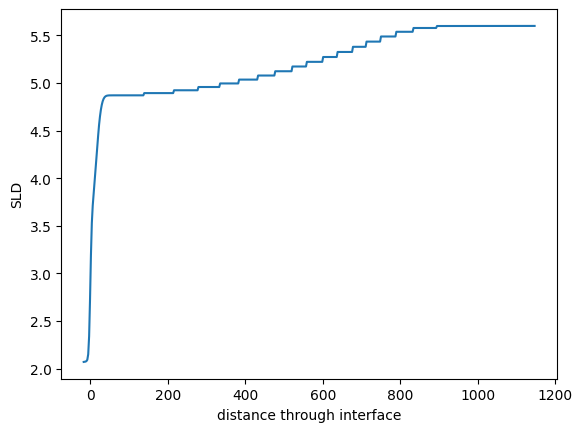

In [5]:
plt.plot(*known_sld_profile);
plt.ylabel("SLD")
plt.xlabel("distance through interface");

In [6]:
# create some SLD objects
# units are 10**-6 Å**-2
si = SLD(2.07)
sio2 = SLD(3.47)
dtol = SLD(5.6)
polymer = SLD(1.4)

In the above equation we scale $S$ by dividing the right hand side by a value $\alpha$, which is also allowed to vary in the fit. We will say that `alpha`'s prior follows a Beta distribution in which lower values of `alpha` are more probable (thereby making the entropic penalty larger).

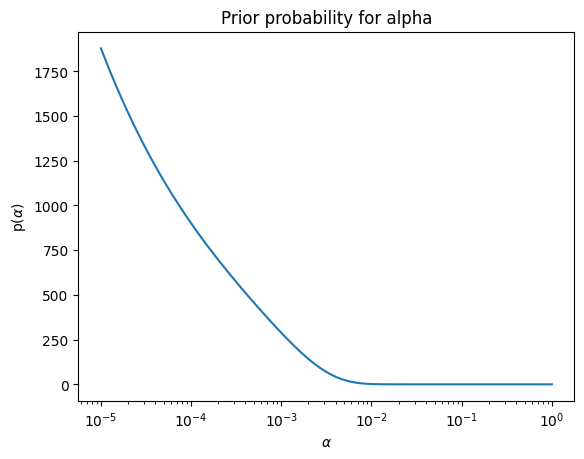

In [7]:
dist = beta(0.7, 500)
alpha = Parameter(0.01, 'alpha', vary=True)
alpha.bounds = PDF(dist)  # specify that alpha's prior is a beta distribution.

_x = np.geomspace(1e-5, 1, 1001)
plt.plot(_x, dist.pdf(_x))
plt.xscale('log')
plt.ylabel('p($\\alpha$)')
plt.xlabel('$\\alpha$')
plt.title("Prior probability for alpha");

Now setup the `MaxEnt` Component. The order of parameters below is:
- number of pixels
- how broad each pixel is. This value becomes the `slab_thickness` attribute, which is a `Parameter`.
- lower bound of the SLD for each pixel.
- upper bound of the SLD for each pixel.
- $m_j$ the default model value for each pixel.
- the alpha scaling parameter

In [8]:
maxent = MaxEnt(50, 18, 4, 5.6, mj=5.2, alpha=alpha)
for p in maxent.vff:
    p.setp(vary=True)  # allow the SLD of each pixel to vary.

# The thickness of each pixel.
# if need be you can allow this parameter to vary, via maxent.slab_thickness.vary = True
print(maxent.slab_thickness)  

<Parameter:      ''       , value=18  (fixed) , bounds=[-inf, inf]>


In [9]:
# create the starting structure
s = si | sio2(15, 3) | maxent | dtol(0, 3)

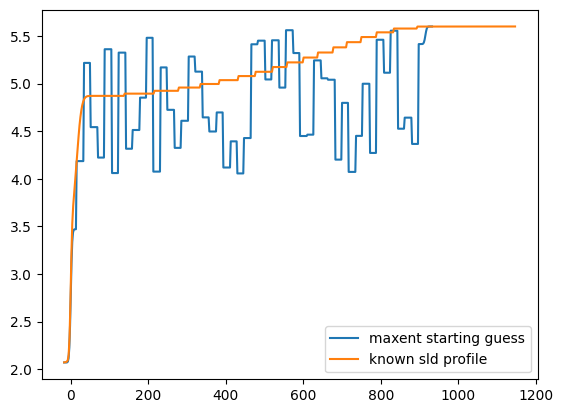

In [10]:
fig, ax = plt.subplots()
ax.plot(*s.sld_profile(), label='maxent starting guess')
ax.plot(*known_sld_profile, label='known sld profile')
plt.legend();

In [11]:
model = ReflectModel(s)
model.bkg.setp(vary=True, bounds=(1e-7, 1e-6))

We need to add `alpha` as an `auxiliary_param` to allow it to vary in the fit.

In [12]:
objective = Objective(model, data, auxiliary_params=(alpha,))

In [13]:
fitter = CurveFitter(objective)

It's important to fit using `target='nlpost'`, which minimises the negative log-posterior. This is to allow the prior term for `alpha` to influence the fit. 

Normally curvefitting minimises the negative log-likelihood. The prior terms do not contribute to the log-likelihood. Thus the optimiser has no incentive to make `alpha` smaller (and $S$ larger).
By minimising the log-posterior, which the log-prior of all the Parameters contribute to, the value of `alpha` is driven to be a smaller value, because smaller values are more probable (see $p(\alpha)$ graph above).

In [14]:
fitter.fit('differential_evolution', target='nlpost', seed=rng);

-1181.1134453582779: : 271it [03:15,  1.38it/s]
/Users/andrew/miniconda3/envs/dev3/lib/python3.12/site-packages/refnx/analysis/objective.py:787: LinAlgWarning: The following Parameters have no effect on Objective.residuals, please consider fixing them.
[Parameter(value=0.007935543455100036, name='alpha', vary=True, bounds=PDF(<scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1631e0230>), constraint=None)]
  warnings.warn(


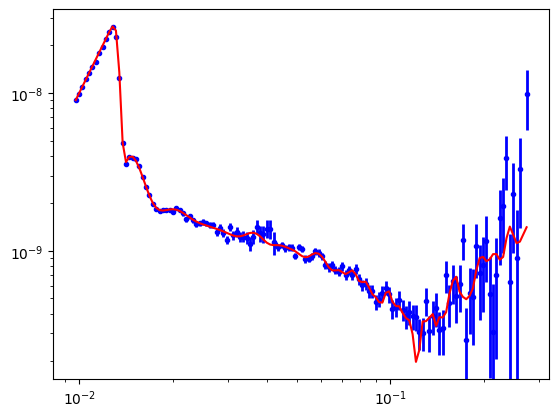

In [15]:
t = Transform('YX4')
objective.transform = t # only done so we can plot as RQ**4 vs Q
objective.plot()
objective.t = None
plt.yscale('log')
plt.xscale('log')

We can see that the MaxEnt reproduces the unknown structure, with little assumed prior knowledge of the system. This profile could then be used as a basis to create a more detailed model; in this case we know that the volume fraction of the polymer brush is parabolic.

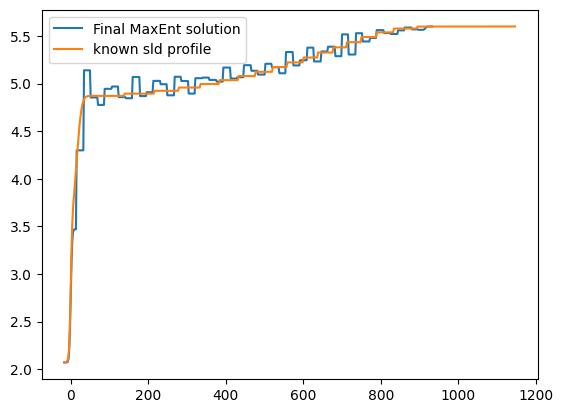

In [16]:
fig, ax = plt.subplots()
ax.plot(*s.sld_profile(), label='Final MaxEnt solution')
ax.plot(*known_sld_profile, label='known sld profile')
plt.legend();